In [2]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
from numrisk.fmri_analysis.gradients.utils import cleanTS, get_glasser_parcels
import seaborn as sns
import pandas as pd
import os
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = os.path.join(bids_folder, 'plots_and_ims/glm_conn_ppi')
os.makedirs(plot_folder) if not op.exists(plot_folder) else None

# group list
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

# Get Glasser parcellation and mask
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping, get_glasser_parcels
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from brainspace.utils.parcellation import map_to_labels
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

from utils_01 import get_cleanTS_run, get_events_confounds
import statsmodels.api as sm

In [3]:
psy_context1 = 'stimulus1_int'
psy_context2 = 'stimulus2_int'
regressors_names = ['seedTS', 'psy_context1', 'psy_context2', 'seedTS:psy_context1', 'seedTS:psy_context2']
formula = 'targetTS ~ ' + ' + '.join(regressors_names)


In [5]:
subject = 1
sub = f'{int(subject):02d}'

# prep data
DMs = []
TSs = []
for run in range(1, 7):
    try:
        dm = get_events_confounds(sub, ses=1, run=run, bids_folder=bids_folder)
        dm['run'] = run
        ts = get_cleanTS_run(sub, run=run, bids_folder=bids_folder)

        TSs.append(ts)
        DMs.append(dm)
    except:
        print(f'!!! ------ problems for run {run} (sub {sub} )')
dm = pd.concat(DMs) # 1128 timesteps = 188 x 6
dm.index.name = 'onset'
dm.set_index('run',append=True,inplace=True)

TSs = np.array(TSs)
TSs = TSs.transpose(1, 0, 2).reshape(TSs.shape[1], (TSs.shape[0]*TSs.shape[2])) # concatenate runs
clean_ts = reduce_by_labels(TSs[mask_glasser], labeling_glasser[mask_glasser], axis=1, red_op='mean',dtype=float)


A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [ ]:
#Fit model

target_folder = op.join(bids_folder,'derivatives','correlation_matrices')
tvals = {param: [] for param in regressors_names}

tvals_mat = np.zeros((len(tvals.keys()), 360,360))
for seed_parcel_n in range(360):
  seedTS = clean_ts[seed_parcel_n]
  for target_parcel_n in range(seed_parcel_n, 360):  # Start from seed_parcel_n to only compute upper triangular part
    df_glm = pd.DataFrame(np.array([seedTS, clean_ts[target_parcel_n], dm[psy_context1], dm[psy_context2]]).T, columns = ['seedTS','targetTS','psy_context1', 'psy_context2'])
    result = sm.formula.ols(formula=formula, data=df_glm).fit()
    for i, param in enumerate(tvals.keys()):
        tvals_mat[i, seed_parcel_n, target_parcel_n] = result.tvalues[param]
        tvals_mat[i, target_parcel_n, seed_parcel_n] = result.tvalues[param] # symetric!

np.save(op.join(target_folder, f'sub-{sub}_PPI-allParamsMatrices.npy'), tvals_mat)


## Gradients on PPI matrices

In [12]:
sub = 1
sub = f'{sub:02d}'

source_folder = op.join(bids_folder,'derivatives','correlation_matrices')
fn = op.join(source_folder, f'sub-{sub}_PPI-allParamsMatrices.npy')

ppi_cms_ = np.load(fn)
ppi_cms = {}
for i, name in enumerate(regressors_names):
    ppi_cms[name] = ppi_cms_[i]

In [13]:
param = 'seedTS:psy_context1' # should be "normal" CM without task stimuli effects
cm = ppi_cms[param]

n_components = 10
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
gm = GradientMaps(n_components=n_components, kernel = 'normalized_angle', approach='dm',random_state=0) # 
gm.fit(cm)

grad = [None] * n_components
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, labeling_glasser, mask=mask_glasser, fill=np.nan)
print('gradients generated')

gradients generated


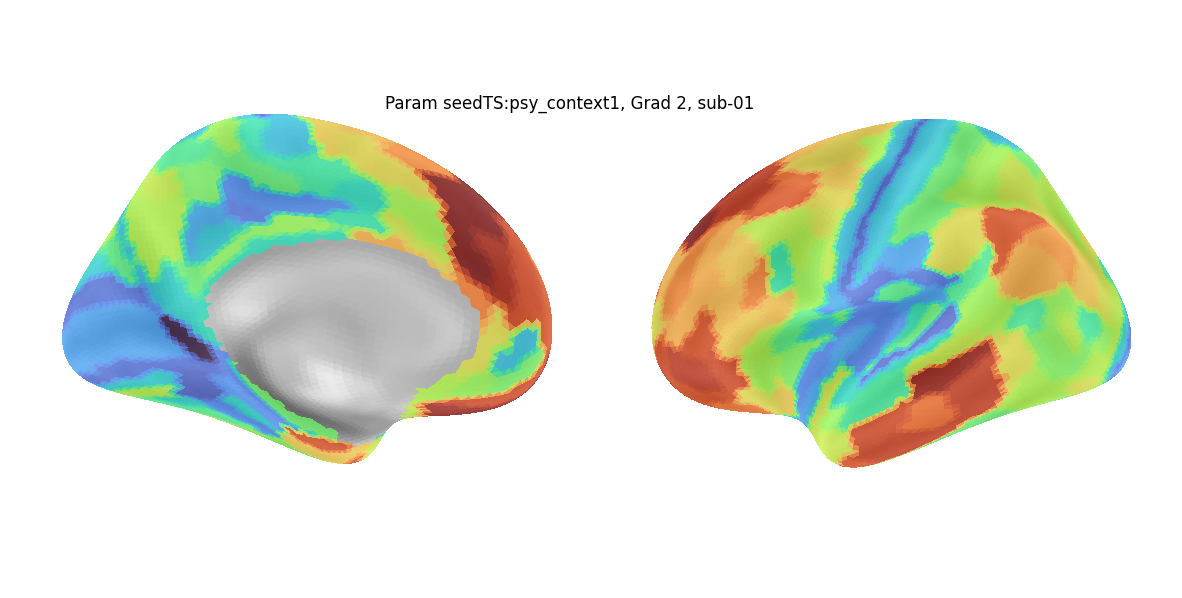

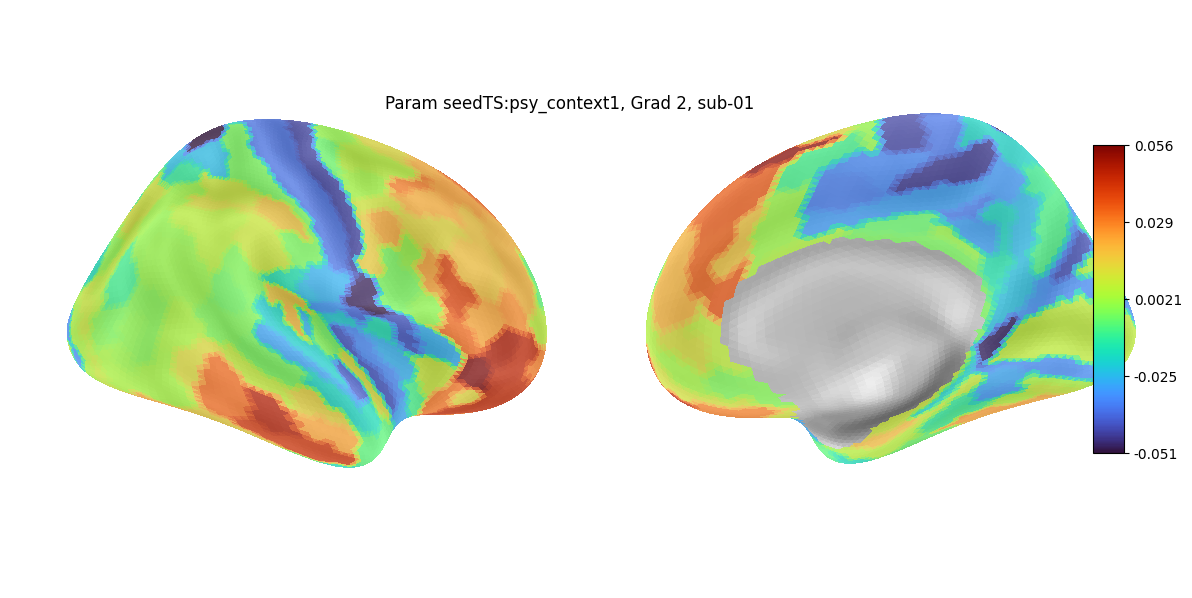

In [14]:
n_grad = 2
gm = grad[n_grad-1]

cmap = 'turbo'
views = ['medial','lateral']
for i, hemi in enumerate(['L','R']):
    map = np.split(gm,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'lateral' and hemi == 'R' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, # infl_right # pial_right
                view= view,cmap=cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'Param {param}, Grad {n_grad}, sub-{sub} ', y=0.75)

Text(0.5, 0.71, 'Param seedTS:psy_context1, \n Grad 5,  sub-01')

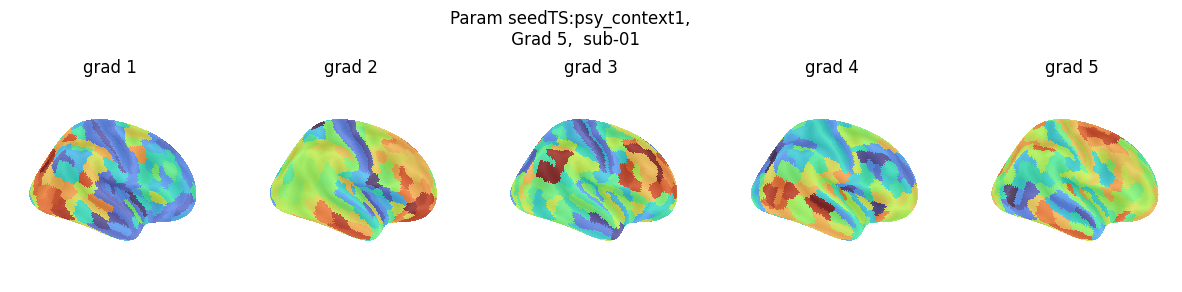

In [15]:
n_comp = 5
side_view = 'medial'
figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,8), subplot_kw=dict(projection='3d'))
for i in range(0,n_comp):
    n_grad= i+1
    gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_r = gm[1]
    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r,avg_method="median", # infl_right # pial_right
                view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
    axes[i].set(title=f'grad {n_grad}')
figure.suptitle(f'Param {param}, \n Grad {n_grad},  sub-{sub}',y = 0.71 )

gradients generated
gradients generated
gradients generated
gradients generated
gradients generated


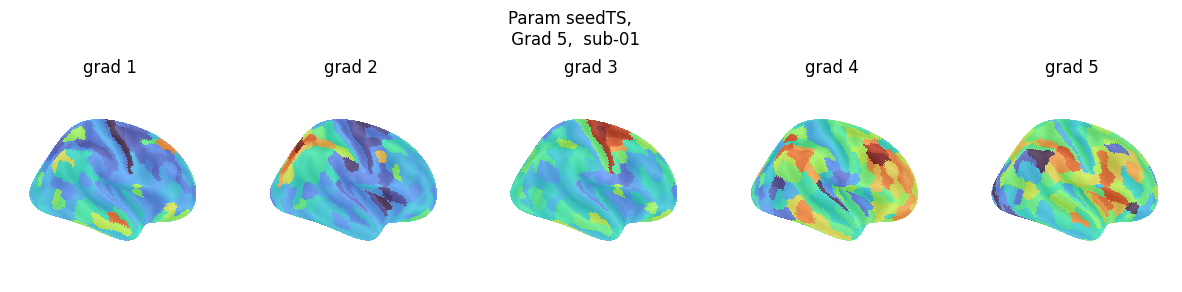

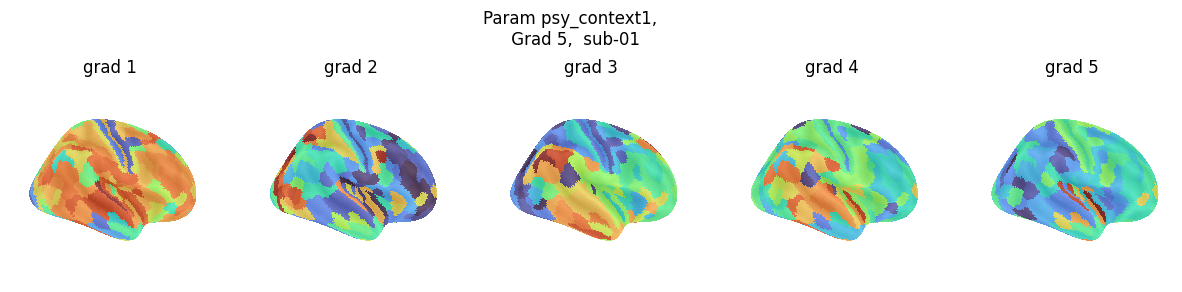

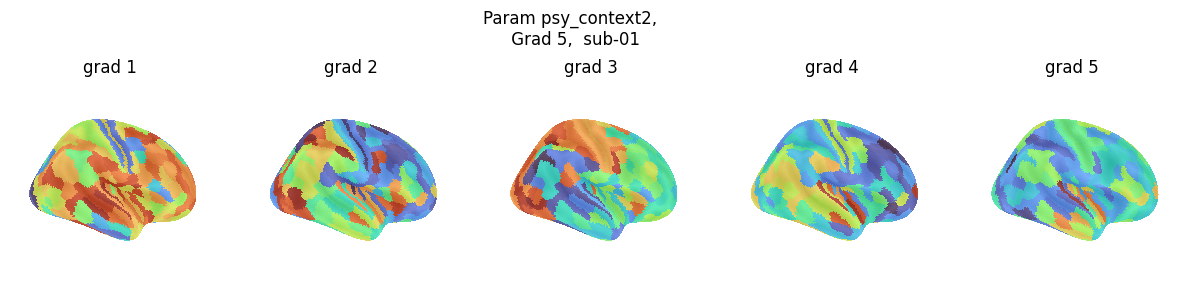

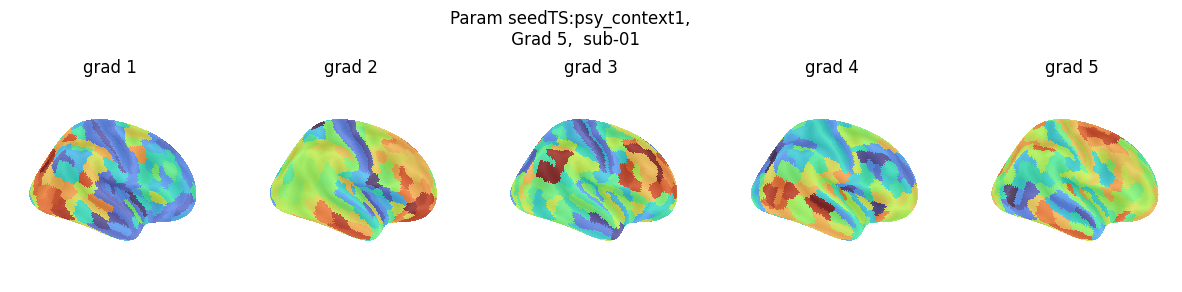

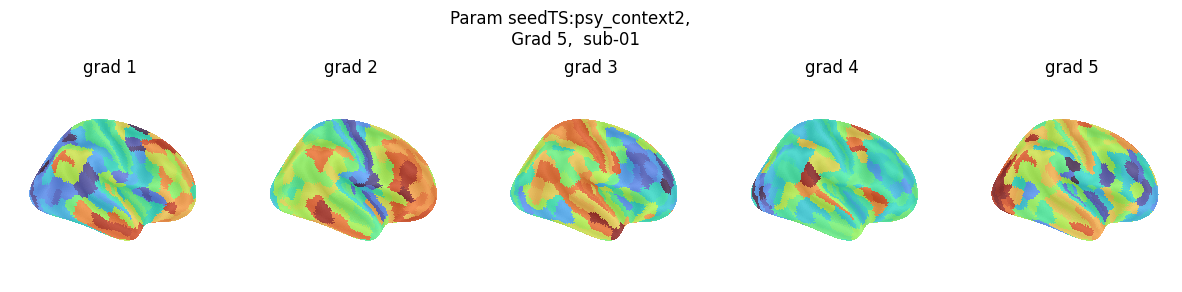

In [16]:
for param in regressors_names:

    cm = ppi_cms[param]

    n_components = 10
    from brainspace.gradient import GradientMaps
    from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
    gm = GradientMaps(n_components=n_components, kernel = 'normalized_angle', approach='dm',random_state=0) # 
    gm.fit(cm)

    grad = [None] * n_components
    for i, g in enumerate(gm.gradients_.T):
        grad[i] = map_to_labels(g, labeling_glasser, mask=mask_glasser, fill=np.nan)
    print('gradients generated')

    # plot
    n_comp = 5
    side_view = 'medial'
    figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i in range(0,n_comp):
        n_grad= i+1
        gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
        gm_r = gm[1]
        nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r,avg_method="median", # infl_right # pial_right
                    view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                    bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7 ,axes=axes[i]) #
        axes[i].set(title=f'grad {n_grad}')
    figure.suptitle(f'Param {param}, \n Grad {n_grad},  sub-{sub}',y = 0.71 )